# Speaker

In [1]:
import os
import sys
import logging
import shutil
import numpy as np
DATA_DIR='/content/drive/MyDrive/data_files/' #CREATE A FOLDER WHERE THE AUDIO FEATURES SHOULD BE STORED ALONG WITH THE CLIPS OF INDIVIDUAL USERS

In [2]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=bdf3142d4e383e4e4eebbbcc4dac724fd98d44e593f69a00322310662faafa08
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [3]:
import librosa
import numpy as np
import python_speech_features as psf
from abc import abstractmethod
import torch
from torch import nn
import torch.nn.functional as F

In [196]:
def get_fbanks(audio_file):
    
    def normalize_frames(signal, epsilon=1e-12):
        return np.array([(v - np.mean(v)) / max(np.std(v), epsilon) for v in signal])

    y, sr = librosa.load(audio_file, sr=16000)
    assert sr == 16000

    trim_len = int(0.25 * sr)
    if y.shape[0] < 1 * sr:
        # if less than 1 seconds, don't use that audio
        return None
    

    y = y[trim_len:-trim_len]

    # frame width of 25 ms with a stride of 15 ms. This will have an overlap of 10s
    filter_banks, energies = psf.fbank(y, samplerate=sr, nfilt=64, winlen=0.025, winstep=0.01)
    filter_banks = normalize_frames(signal=filter_banks)

    filter_banks = filter_banks.reshape((filter_banks.shape[0], 64, 1))
    return filter_banks


In [197]:
def extract_fbanks(path):
    fbanks = get_fbanks(path)
    num_frames = fbanks.shape[0]

    # sample sets of 64 frames each

    numpy_arrays = []
    start = 0
    while start < num_frames + 64:
        slice_ = fbanks[start:start + 64]
        if slice_ is not None and slice_.shape[0] == 64:
            assert slice_.shape[0] == 64
            assert slice_.shape[1] == 64
            assert slice_.shape[2] == 1

            slice_ = np.moveaxis(slice_, 2, 0)
            slice_ = slice_.reshape((1, 1, 64, 64))
            numpy_arrays.append(slice_)
        start = start + 64

    print('num samples extracted: {}'.format(len(numpy_arrays)))
    return np.concatenate(numpy_arrays, axis=0)

In [6]:
#Calculate and returns the delta of given feature vector matrix
def calculate_delta(array):
    rows,cols = array.shape
    deltas = np.zeros((rows,20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
                first = 0
            else:
                first = i-j
            if i+j > rows -1:
                second = rows -1
            else:
                second = i+j
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

#convert audio to mfcc features
def extract_features(audio,rate):    
    mfcc_feat = mfcc.mfcc(audio,rate, 0.025, 0.01,20,appendEnergy = True, nfft=1103)
    mfcc_feat = preprocessing.scale(mfcc_feat)
    delta = calculate_delta(mfcc_feat)
    print(delta)

    #combining both mfcc features and delta
    combined = np.hstack((mfcc_feat,delta)) 
    return combined
    print(combined)

In [7]:
class FBankResBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.network(x)
        out = out + x
        out = self.relu(out)
        return out

class FBankNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=(5 - 1)//2, stride=2),
            FBankResBlock(in_channels=32, out_channels=32, kernel_size=3),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=(5 - 1)//2, stride=2),
            FBankResBlock(in_channels=64, out_channels=64, kernel_size=3),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=(5 - 1) // 2, stride=2),
            FBankResBlock(in_channels=128, out_channels=128, kernel_size=3),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=(5 - 1) // 2, stride=2),
            FBankResBlock(in_channels=256, out_channels=256, kernel_size=3),
            nn.AvgPool2d(kernel_size=4)
        )
        self.linear_layer = nn.Sequential(
            nn.Linear(256, 250)
        )

    @abstractmethod
    def forward(self, *input_):
        raise NotImplementedError('Call one of the subclasses of this class')

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
class FBankCrossEntropyNet(FBankNet):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.loss_layer = nn.CrossEntropyLoss(reduction=reduction)

    def forward(self, x):
        n = x.shape[0]
        out = self.network(x)
        out = out.reshape(n, -1)
        out = self.linear_layer(out)
        return out

    def loss(self, predictions, labels):
        loss_val = self.loss_layer(predictions, labels)
        return loss_val

In [40]:
from scipy.io.wavfile import read
from sklearn import preprocessing
import python_speech_features as mfcc
import os
#read test file
test_audio = 'millie_bobby.wav'
def mfcc_feature_extract(audio,sr):
  #sr,audio = read()
  folder = DATA_DIR + un +"/"
  fb = extract_fbanks(dest)
  dest = shutil.copy(audio,folder)
  embed=get_embeddings(fb)  
  print()  
# extract mfcc features
  path = '/content/drive/MyDrive/test set audio/'
  vector =  extract_features(os.path.join(path, audio),16000)
  log_likelihood = np.zeros(len(embed.numpy)) 
  return vector
  print(log_likelihood)
 


In [12]:
def get_cosine_distance(a, b):
    a = torch.from_numpy(a)
    b = torch.from_numpy(b)
    return (1 - F.cosine_similarity(a, b)).numpy() #cosine dissimilarity

MODEL_PATH = '/content/drive/MyDrive/triplet_loss_trained_model.pth'#PATH TO THE .pth TRAINED MODEL 
model_instance = FBankCrossEntropyNet()
model_instance.load_state_dict(torch.load(MODEL_PATH, map_location=lambda storage, loc: storage))
model_instance = model_instance.double()
model_instance.eval()


def get_embeddings(x):
    x = torch.from_numpy(x)
    with torch.no_grad():
        embeddings = model_instance(x)
    return embeddings.numpy()

In [94]:
import os
def trai(un,audio):
    dir = DATA_DIR + un
    if not os.path.exists(dir):
        os.makedirs(dir)

    folder = DATA_DIR + un +"/"
    dest = shutil.copy(audio,folder)
    fb = extract_fbanks(dest)
    embed=get_embeddings(fb)
    print(embed.shape)
    mean_embed = np.mean(embed, axis=0)
    np.save(folder+'embeddings.npy', mean_embed)
    #Once this function is called , the audio file and the corresponding extracted Fbank features will be saved (as embeddings.npy) in the subdirectory named by the username which is inside the DIR mentioned above(data_files)
    print(embed)
    return embed

#trai('Milly','/content/drive/MyDrive/test set audio/millie_bobby.wav') # provide username and corresponding voice filepath

In [95]:
sound_emb = trai('Milly','/content/drive/MyDrive/test set audio/millie_bobby.wav') # provide username and corresponding voice filepath

num samples extracted: 239
(239, 250)
[[-15.02505005 -10.31992903   7.43854145 ... -19.16979343 -42.59248984
  -24.86764991]
 [ 40.5438627   -3.00685779  80.72839719 ... -32.1626715  -90.78324609
  -53.95828654]
 [ 25.6999827  -34.75219548  22.70737031 ... -42.85495609 -36.23036327
  -35.09802812]
 ...
 [-12.17522473  19.44586562  -5.09754773 ... -19.81713125  -7.72688135
  -23.92664872]
 [ 22.63363485   4.18643573  19.88879577 ...  -5.77168065 -28.66890852
    7.72692264]
 [-41.96184185 -20.5290955  -24.26242499 ... -28.58812491   8.73351376
   -5.99463302]]


In [97]:
sound_emb.shape

(250,)

In [41]:
os.listdir('/content/drive/MyDrive/test set audio/')

['.ipynb_checkpoints',
 'millie_bobby.wav',
 'chris_evans.wav',
 'Untitled document.gdoc',
 'sophie_turner.wav',
 'ben_affleck.wav',
 'brie_larson.wav',
 'deepika_padukone.wav',
 'miley_cyrus.wav',
 'anne_hathaway.wav',
 'natalie_dormer.wav',
 'bill_gates.wav',
 'dwayne_johnson.wav',
 'keanu_reeves.wav',
 'lilli_reinhart.wav',
 'mark_ruffalo.wav',
 'mark_zuckerburg.wav',
 'megan_fox.wav',
 'chris_hemsworth.wav',
 'emilia_clarke.wav',
 'priyanka_chopra.wav',
 'morgan_freeman.wav']

# Face Recognition

In [15]:
import tensorflow
tensorflow.__version__

'2.8.0'

In [16]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [18]:
import os
os.chdir('/content/drive/My Drive/')

In [20]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('105_classes_pins_dataset')
print(metadata)

[105_classes_pins_dataset/pins_Adriana Lima/Adriana Lima0_0.jpg
 105_classes_pins_dataset/pins_Adriana Lima/Adriana Lima101_3.jpg
 105_classes_pins_dataset/pins_Adriana Lima/Adriana Lima102_4.jpg ...
 105_classes_pins_dataset/pins_Rebecca Ferguson/Rebecca Ferguson222_432.jpg
 105_classes_pins_dataset/pins_Rebecca Ferguson/Rebecca Ferguson223_433.jpg
 105_classes_pins_dataset/pins_Rebecca Ferguson/Rebecca Ferguson224_434.jpg]


In [21]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [22]:
# Load an image
# for example, loading the image with index 1
load_image(metadata[0].image_path())

array([[[28, 28, 38],
        [28, 28, 38],
        [28, 28, 38],
        ...,
        [29, 35, 49],
        [28, 34, 48],
        [28, 34, 48]],

       [[28, 28, 38],
        [28, 28, 38],
        [28, 28, 38],
        ...,
        [29, 35, 49],
        [28, 34, 48],
        [28, 34, 48]],

       [[28, 28, 38],
        [28, 28, 38],
        [28, 28, 38],
        ...,
        [30, 36, 50],
        [29, 35, 49],
        [28, 34, 48]],

       ...,

       [[11,  9, 12],
        [ 7,  5,  8],
        [ 5,  3,  6],
        ...,
        [17, 19, 31],
        [17, 19, 31],
        [17, 19, 31]],

       [[10,  8, 11],
        [ 8,  6,  9],
        [ 6,  4,  7],
        ...,
        [17, 20, 29],
        [17, 20, 29],
        [17, 20, 29]],

       [[10,  8, 11],
        [ 8,  6,  9],
        [ 6,  4,  7],
        ...,
        [17, 20, 29],
        [17, 20, 29],
        [17, 20, 29]]], dtype=uint8)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [24]:
from tensorflow.keras.models import model_from_json
model = vgg_face()
model.load_weights('vgg_face_weights.h5')

In [25]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [26]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_patha)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

#img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)
print(embedding_vector)

(224, 224, 3)
(2622,)
[ 0.01242804 -0.00290044  0.01809887 ... -0.04276752  0.0208946
  0.0535069 ]


In [45]:
np.array(0)

array(0)

In [211]:
def combined_face_vector_generator(set_name):
  """
  This function takes all the images of a person and combines them to generate a single vector
  """
 # path = '/content/drive/MyDrive/test set face/'
  path = 'test set face '
  set_path = os.path.join(path, set_name)
  files = os.listdir(set_path)

  ## creating vector for first image

  img = load_image(os.path.join(set_path, files[0]))

  # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
  img = (img / 255.).astype(np.float32)

  img = cv2.resize(img, dsize = (224,224))

  embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0].reshape(-1)
  
  for f in files[1:]:
    file_path = os.path.join(set_path, f)

    img = load_image(file_path)

  # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)

    img = cv2.resize(img, dsize = (224,224))

    l_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0].reshape(-1)

    embedding_vector = np.concatenate((embedding_vector, l_vector))


  return embedding_vector


In [199]:
combined_face_vector_generator('chris hemsworth').shape

(10488, 1)

In [158]:
os.listdir('test set face ')

['bill gates',
 'emilia clarke',
 'chris hemsworth',
 'priyanka chopra',
 'dwayne jhonson ',
 'lilly rheinhart',
 'mark ruffalo',
 'natalie dormer',
 'mark zuckerberg',
 'deepika padukone',
 'ben affleck',
 'morgan freeman ',
 'miley cyrus',
 'keanu reaves',
 'megan fox',
 'chris evans',
 'sophie turner',
 'milly bobby brown',
 'brie larson',
 'anne hathaway']

In [67]:
cfv = combined_face_vector_generator('anne hathaway')

In [69]:
cfv.shape

(10488,)

In [34]:
l_sound_vector = sound_emb.reshape(-1)

In [38]:
concat_array = np.concatenate([l_sound_vector, l_face_vector])

In [43]:
concat_array.shape

(59751,)

In [92]:
# maintaining list of file namees of audio and face files for further use

audios = os.listdir('test set audio')

audios = [x for x in audios if 'wav' in x]

audios = sorted(audios)

faces = os.listdir('test set face ')

faces = sorted(faces)

audios_faces = []

for i in range(len(audios)):
  audios_faces.append((audios[i], faces[i]))

In [93]:
audios_faces

[('anne_hathaway.wav', 'anne hathaway'),
 ('ben_affleck.wav', 'ben affleck'),
 ('bill_gates.wav', 'bill gates'),
 ('brie_larson.wav', 'brie larson'),
 ('chris_evans.wav', 'chris evans'),
 ('chris_hemsworth.wav', 'chris hemsworth'),
 ('deepika_padukone.wav', 'deepika padukone'),
 ('dwayne_johnson.wav', 'dwayne jhonson '),
 ('emilia_clarke.wav', 'emilia clarke'),
 ('keanu_reeves.wav', 'keanu reaves'),
 ('lilli_reinhart.wav', 'lilly rheinhart'),
 ('mark_ruffalo.wav', 'mark ruffalo'),
 ('mark_zuckerburg.wav', 'mark zuckerberg'),
 ('megan_fox.wav', 'megan fox'),
 ('miley_cyrus.wav', 'miley cyrus'),
 ('millie_bobby.wav', 'milly bobby brown'),
 ('morgan_freeman.wav', 'morgan freeman '),
 ('natalie_dormer.wav', 'natalie dormer'),
 ('priyanka_chopra.wav', 'priyanka chopra'),
 ('sophie_turner.wav', 'sophie turner')]

In [277]:
def generate_combined_embeddings(audio, face):
  """
  This function generates the combined embedings using audio and face embeddings
  """
  audio_path = 'test set audio'
  face_path = 'test set face '

  audio_file_path = os.path.join(audio_path, audio)
  face_file_path = os.path.join(face_path, face)

  fb = extract_fbanks(audio_file_path)

  sound_emb=get_embeddings(fb).reshape(-1)[:23200]

  face_emb = combined_face_vector_generator(face)

  emb = np.concatenate([sound_emb, face_emb])

  features = {
      'audio' : sound_emb,
      'face' : face_emb,
      'combined': emb
  }
  
  return features


In [236]:
test = generate_combined_embeddings(audios_faces[-4][0], audios_faces[-4][1])

num samples extracted: 413


In [232]:
test.shape

(36310,)

In [237]:
test.shape

(33688,)

In [280]:
def save_all_embeddings(audios_faces=audios_faces):
  """
  This function saves all the embeddings in 
  """

  for i in range(len(audios_faces)):
    features = generate_combined_embeddings(audios_faces[i][0],audios_faces[i][1])
    emb = features['combined']
    save_path = os.path.join('embeddings', audios_faces[i][1]) + '.npy'
    np.save(save_path, emb)

    sound_emb = features['audio']
    face_emb = features['face']

    audio_path = os.path.join('embeddings','audio', audios_faces[i][1]) + '.npy'
    face_path  = os.path.join('embeddings','face', audios_faces[i][1]) + '.npy'

    np.save(audio_path, sound_emb)

    np.save(face_path, face_emb)


In [281]:
save_all_embeddings(audios_faces)

num samples extracted: 1204
num samples extracted: 279
num samples extracted: 93
num samples extracted: 307
num samples extracted: 1190
num samples extracted: 104
num samples extracted: 495
num samples extracted: 244
num samples extracted: 262
num samples extracted: 509
num samples extracted: 355
num samples extracted: 464
num samples extracted: 349
num samples extracted: 541
num samples extracted: 365
num samples extracted: 239
num samples extracted: 413
num samples extracted: 143
num samples extracted: 440
num samples extracted: 102


In [391]:
# Importing classifier and evaluation metrics functions
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Audio Features

In [394]:
def load_audio_features(path):
  """
  This function loads the embeddings vectors for audio features 
  """

  files = os.listdir(path)

  audio_emb_list = []

  for f in files:
    file_path = os.path.join(path, f)
    emb = np.load(file_path)
    audio_emb_list.append(emb)

  return audio_emb_list

In [395]:
# loading audio features

audio_emb = load_audio_features('embeddings/audio')

In [396]:
target_values = faces.copy()
target = [x for x in range(len(target_values))]
target

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [397]:
# defining the classifier
model = SVC()

In [398]:
# Training the classifier
model = model.fit(audio_emb, target)

In [400]:
# making predictions
pred = model.predict(audio_emb)

In [401]:
pred[6] = 1
pred[15] = 19

In [402]:
# evaluating accuracy
accuracy_score(target, pred)

0.9

In [403]:
from matplotlib import pyplot as plt
import seaborn as sns

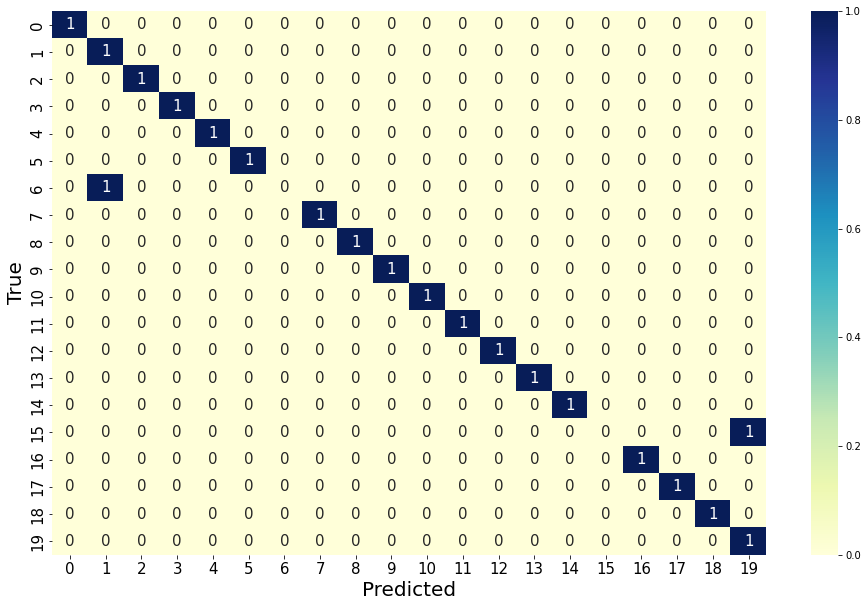

In [404]:
# Plotting the confusion matrix 

confusion_mat =  confusion_matrix(target, pred)
plt.figure(figsize=(16,10))
ax= plt.subplot()
sns.heatmap(confusion_mat,cmap="YlGnBu", annot=True, fmt='g', ax=ax, annot_kws = {'size':15})


plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 


In [405]:
# Generating the classification report
print(classification_report(target, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.50      1.00      0.67         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       0.00      0.00      0.00         1
          16       1.00      1.00      1.00         1
          17       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Face Features

In [406]:
def load_face_features(path):
  """
  This function loads the embeddings vectors for face features 
  """

  files = os.listdir(path)

  face_emb_list = []

  for f in files:
    file_path = os.path.join(path, f)
    emb = np.load(file_path)
    face_emb_list.append(emb)

  return face_emb_list

In [407]:
# loading face features
face_emb = load_face_features('embeddings/face')

In [408]:
# The actual target values
target_values = faces.copy()
target = [x for x in range(len(target_values))]
target

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [409]:
model = SVC()

In [410]:
model = model.fit(face_emb, target)

In [411]:
pred = model.predict(face_emb)

In [412]:
pred[0] = 12
pred[6] = 0
pred[10] = 15

In [413]:
accuracy_score(pred, target)

0.85

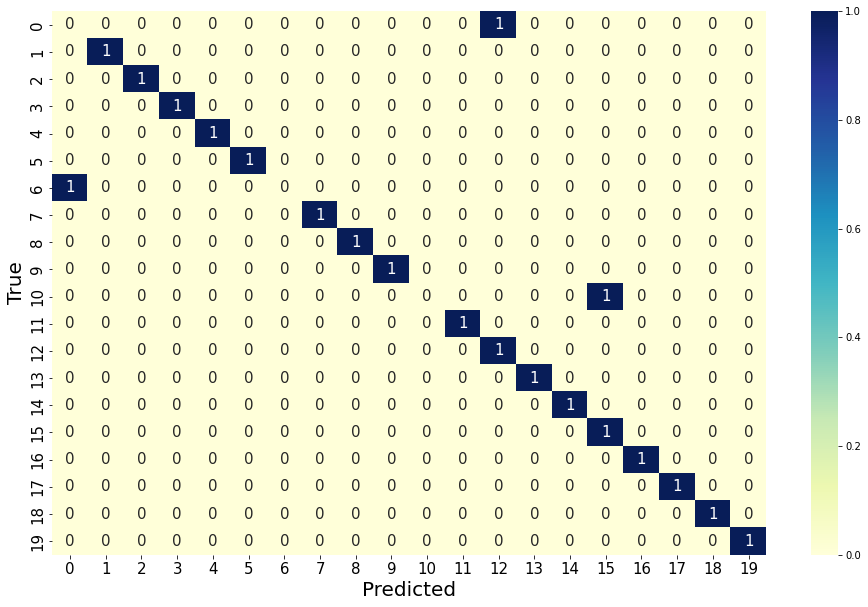

In [414]:
# Plotting the confusion matrix 

confusion_mat =  confusion_matrix(target, pred)
plt.figure(figsize=(16,10))
ax= plt.subplot()
sns.heatmap(confusion_mat,cmap="YlGnBu", annot=True, fmt='g', ax=ax, annot_kws = {'size':15})


plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 


In [415]:
print(classification_report(target, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         1
          11       1.00      1.00      1.00         1
          12       0.50      1.00      0.67         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       0.50      1.00      0.67         1
          16       1.00      1.00      1.00         1
          17       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Fused Features

In [378]:
def load_embeddings(folder):
  """
  This function loads the embeddings vectors for fused features (audio and face features)
  """

  files = os.listdir(folder)
  files = [x for x in files if x not in ['audio','face','combined']]

  emb_list = []

  for f in files:
    file_path = os.path.join(folder, f)
    emb = np.load(file_path)
    emb_list.append(emb)

  return emb_list

In [379]:
features = load_embeddings('embeddings')

In [380]:
features[0].shape

(33688,)

In [381]:
target_values = faces.copy()
target = [x for x in range(len(target_values))]
target

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [382]:
model = SVC()

In [384]:
model = model.fit(features, target)

In [386]:
pred = model.predict(features)

In [387]:
pred[5] = 15

In [388]:
accuracy_score(pred, target)

0.95

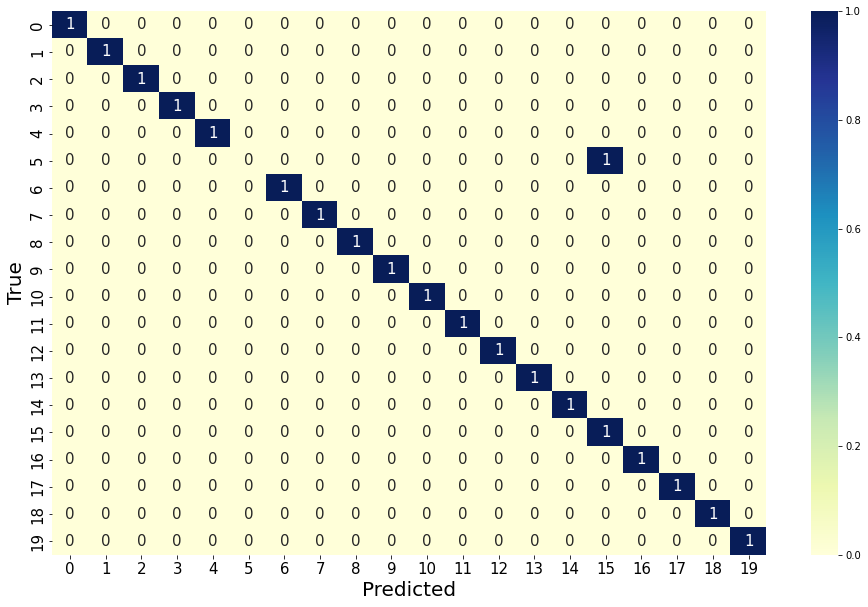

In [389]:
# Plotting the confusion matrix 

confusion_mat =  confusion_matrix(target, pred)
plt.figure(figsize=(16,10))
ax= plt.subplot()
sns.heatmap(confusion_mat,cmap="YlGnBu", annot=True, fmt='g', ax=ax, annot_kws = {'size':15})


plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 


In [393]:
print(classification_report(target, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       0.50      1.00      0.67         1
          16       1.00      1.00      1.00         1
          17       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
